In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.special import softmax
import matplotlib.pyplot as plt
import ex_fuzzy.fuzzy_sets as fs
import ex_fuzzy.evolutionary_fit as GA
import ex_fuzzy.utils as  utils
import ex_fuzzy.eval_tools as eval_tools
import ex_fuzzy.persistence as persistence
import ex_fuzzy.vis_rules as vis_rules
import ex_fuzzy.classifiers as classifiers
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import StandardScaler

#### Create dataset with style characteristics, Grad-CAM metrics, and dominant deep features

In [2]:
style_data = pd.read_csv(r'.\\Data\style_predictions.csv', index_col=0)
gradcam_data = pd.read_csv(r'.\\Data\gradcam_features.csv', index_col='name')
gradcam_data.drop('Unnamed: 0', axis=1, inplace=True)
gradcam_data = gradcam_data[gradcam_data.index.isin(style_data.index)]
style_data = style_data[style_data.index.isin(gradcam_data.index)]
aux = pd.concat([style_data, gradcam_data], axis=1, ignore_index=False)
deep_features = pd.read_csv(r'.\\Data\\deep_features.csv', index_col=0)
deep_features = deep_features[deep_features.index.isin(aux.index)]
dominant_features = deep_features.values.argmax(axis=1)
aux["dominant_feature"] = dominant_features
aux

,Abstract_Expressionism,Action_painting,Analytical_Cubism,Art_Nouveau,Baroque,Color_Field_Painting,Contemporary_Realism,Cubism,Early_Renaissance,Expressionism,...,Realism,Rococo,Romanticism,Symbolism,Synthetic_Cubism,Ukiyo_e,relevant_area,maximum_gradient,super_regions,dominant_feature
26638-05_1pr4.jpg,-7.063129,-2.508343,3.725084,-3.285906,-0.277872,-2.669759,-1.775650,0.157262,15.554424,-2.077867,...,-6.570203,-1.797319,-4.315772,1.474725,-2.005098,-2.197864,0.367347,2.980095,4,15
15014-tahiti72.jpg,-2.462697,-2.134319,-0.966864,0.684325,-3.171190,-4.274874,-0.902123,3.063664,-2.289463,14.858156,...,-2.266230,-6.081960,-3.350481,1.576499,-1.215591,-1.234233,0.387755,3.713520,1,10
15023-marque06.jpg,-6.146632,-2.701967,-1.010856,2.096929,-2.940221,-5.425075,-0.779194,4.196387,-1.708815,7.112885,...,1.954151,-3.485067,0.433324,0.407096,-1.351914,-2.630281,0.448980,3.327481,2,15
33575-104portr.jpg,-1.041784,-1.786637,-0.370458,-3.930660,14.952488,-3.411912,-2.770083,-0.015199,-3.126855,-1.678638,...,-2.256901,-2.824393,3.046533,4.681930,-1.264384,-1.227411,0.326531,3.253300,1,9
26581-05_3ce5.jpg,-5.987647,-2.543383,0.434927,-0.083185,4.059253,-4.999323,-3.554768,-0.311486,4.421210,-2.550407,...,-5.515227,-1.500054,1.297658,-0.874837,-1.494430,-0.462578,0.448980,3.379565,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32818-31anside.jpg,-7.304351,-2.350338,1.044083,-0.543261,-1.550391,-3.365272,-2.664943,-0.232909,11.585092,-2.073384,...,-5.620552,-1.662448,5.086208,3.365484,-2.976781,-2.036824,0.367347,3.606278,4,7
23836-2manet15.jpg,-4.327446,-1.471331,-3.257798,5.355067,-3.695203,-5.009962,1.138126,-0.964523,-2.276172,2.423120,...,1.231028,1.055217,2.784793,4.311680,-3.943966,-2.544454,0.306122,3.486145,4,5
33642-01landsc.jpg,-4.680117,-2.855104,-1.311651,-6.829466,21.253212,-5.014223,-2.132906,-1.470421,-4.151751,-2.965189,...,6.868562,6.040254,12.986197,0.625066,-1.506558,-0.100603,0.428571,3.467604,1,4
13415-21paele0.jpg,-7.225070,-2.807104,-0.330903,2.332960,2.212129,-4.160635,-1.533496,-2.952474,11.576078,-5.660864,...,-2.187302,-0.426667,11.375315,5.164935,-2.214153,-2.143899,0.387755,2.774775,1,8


In [3]:
aux.to_csv(r'.\\Data\explainable_features.csv')

#### Set up experiment to compare 7 painters

Experiment is adapted from code: https://github.com/Fuminides/context-art-classification/blob/master/Infus_experiments_rules_data/gogh_gauguin.py

In [4]:
authors = ['GOGH, Vincent van', 'MONET, Claude', 'GAUGUIN, Paul', 'MANET, Edouard',
           'RAFFAELLO Sanzio','REMBRANDT Harmenszoon van Rijn','EYCK, Jan van']

In [5]:
def load_explainable_features(path=r'.\\Data\\explainable_features.csv'):
    data = pd.read_csv(path, index_col=0) 
    data.fillna(0, inplace=True)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    return X, y

In [6]:
# Load SemArt dataset
semart_path = r'.\\Data\\'
semart_train = pd.read_csv(semart_path + 'semart_train.csv', encoding='cp1252', sep='\t')
X, y = load_explainable_features()

In [7]:
# Create datasets for artist pairing 

def create_artist_dataset(X, y, artist): 
    artist_df = semart_train[semart_train['AUTHOR'] == artist]
    X_artist = X.loc[artist_df['IMAGE_FILE']]
    return X_artist

def create_full_dataset(X, y, artist1, artist2):
    X_a1 = create_artist_dataset(X, y, artist1)
    X_a2 = create_artist_dataset(X, y, artist2)
    y_artists = np.zeros(X_a1.shape[0] + X_a2.shape[0])
    y_artists[:X_a1.shape[0]] = 1

    y_artists = pd.Series(y_artists)
    y_artists = y_artists.replace({1: artist1, 0: artist2})

    X_artists = pd.concat([X_a1, X_a2])

    return X_artists, y_artists

In [8]:
# Create PCA and TSNE plots 
def dimensionality_reduction_plots(X_artists, y_artists):
    
    fig, axes = plt.subplots(1, 2 ,figsize=(10,5))
    
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    X_artists_tsne = tsne.fit_transform(X_artists)
    X_artists_tsne = pd.DataFrame(X_artists_tsne, columns=['TSNE1', 'TSNE2'])
    X_artists_tsne['AUTHOR'] = y_artists

    pca = PCA(n_components=2)
    X_artists_pca = pca.fit_transform(X_artists)
    X_artists_pca = pd.DataFrame(X_artists_pca, columns=['PC1', 'PC2'])
    X_artists_pca['AUTHOR'] = y_artists
  
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='AUTHOR', data=X_artists_tsne, ax=axes[0])
    sns.scatterplot(x='PC1', y='PC2', hue='AUTHOR', data=X_artists_pca, ax=axes[1])
    plt.show()

In [9]:
# Train GBC, fine feature importance, and retrain GBC 
def gbc_finetune(X, X_artists, y_artists): 
    X_artists_train, X_artists_test, y_artists_train, y_artists_test = train_test_split(X_artists, y_artists, test_size=0.20, random_state=42, stratify=y_artists)
    
    scaler = StandardScaler()
    X_artists_train_scaled = scaler.fit_transform(X_artists_train)
    X_artists_test_scaled = scaler.transform(X_artists_test)
    
    classifier = GradientBoostingClassifier(learning_rate=0.1, random_state=0)
    classifier.fit(X_artists_train_scaled, y_artists_train)
    y_pred = classifier.predict(X_artists_test_scaled)
    print('Accuracy of the classifier: ', accuracy_score(y_artists_test, y_pred))

    importances = classifier.feature_importances_
    importance_threshold = 0.025
    
    num_features = np.sum(importances > importance_threshold)

    if num_features < 5: 
        importances = sorted(importances, reverse=True)
        importance_threshold = importances[4]

    print('Number of features used: ' + str(num_features))
    
    X = X.iloc[:, importances >= importance_threshold]
    X_artists_train = X_artists_train.iloc[:, importances >= importance_threshold]
    X_artists_test = X_artists_test.iloc[:, importances >= importance_threshold]

    print('Important features:' + str(list(X.columns)))

    classifier = GradientBoostingClassifier(learning_rate=0.1, random_state=0)
    classifier.fit(X_artists_train, y_artists_train)
    y_pred = classifier.predict(X_artists_test)
    print('Accuracy of the classifier with reduced dimensions: ', accuracy_score(y_artists_test, y_pred))
    print('Matthews correlation coefficient: ', matthews_corrcoef(y_artists_test, y_pred))

    return X, X_artists_train, y_artists_train, X_artists_test, y_artists_test

#### Set up Fuzzy Rule-Based Classification

In [10]:
# Default params
threads = 1 # 1: single thread, 2+: corresponding multi-thread
n_gen = 100
n_pop = 50
nRules = 15
nAnts = 4
vl = 3
tolerance = 0.1
fz_type_studied = fs.FUZZY_SETS.t1

In [11]:
# Function to generate fuzzy rules for a pair of artists
def generate_rules(X, X_artists_train, y_artists_train, X_artists_test, y_artists_test):
    fz_type_studied = fs.FUZZY_SETS.t1

    precomputed_partitions = utils.construct_partitions(X, fz_type_studied)
    min_bounds = np.min(X, axis=0).values
    max_bounds = np.max(X, axis=0).values
    domain = [min_bounds, max_bounds]

    y_artists_train = y_artists_train.reset_index(drop=True)
    y_artists_test = y_artists_test.reset_index(drop=True)
    
    print('Training fuzzy classifier:' , nRules, 'rules, ', nAnts, 'ants, ', n_gen, 'generations, ', n_pop, 'population size')
    fl_classifier = classifiers.FuzzyRulesClassifier(nRules=nRules, nAnts=nAnts, fuzzy_type=fz_type_studied, linguistic_variables=precomputed_partitions, verbose=False, tolerance=tolerance, runner=threads)
    fl_classifier.fit(X_artists_train, y_artists_train, n_gen=n_gen, pop_size=n_pop)

    str_rules = eval_tools.eval_fuzzy_model(fl_classifier.internal_classifier(), X_artists_train, y_artists_train, X_artists_test, y_artists_test,
                        plot_rules=False, print_rules=True, plot_partitions=False, return_rules=True)

#### Run Experiment

*********************************************************
GOGH, Vincent van and MONET, Claude
*********************************************************
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 383 samples in 0.000s...
[t-SNE] Computed neighbors for 383 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 383 / 383
[t-SNE] Mean sigma: 5.705826
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.062965
[t-SNE] KL divergence after 300 iterations: 0.923204


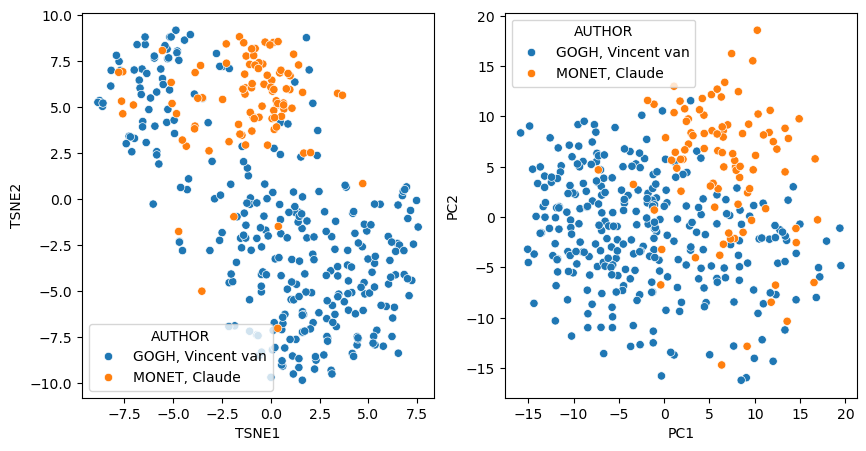

Accuracy of the classifier:  0.8831168831168831
Number of features used: 6
Important features:['Color_Field_Painting', 'Cubism', 'Expressionism', 'Impressionism', 'Post_Impressionism', 'Rococo']
Accuracy of the classifier with reduced dimensions:  0.8961038961038961
Matthews correlation coefficient:  0.694340858564394
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.8627450980392157
Test performance: 0.8051948051948052
------------
MATTHEW CORRCOEF
Train performance: 0.6405048700712856
Test performance: 0.44581598498790503
------------
Rules for consequent: GOGH, Vincent van
----------------
IF Impressionism IS Medium AND Rococo IS Medium WITH DS 0.12219405015901243, ACC 0.875
IF Impressionism IS Medium WITH DS 0.3653933591535715, ACC 0.9609375

Rules for consequent: MONET, Claude
----------------
IF Expressionism IS Low AND Post_Impressionism IS High AND Rococo IS Medium WITH DS 0.19391543383677612, ACC 0.85

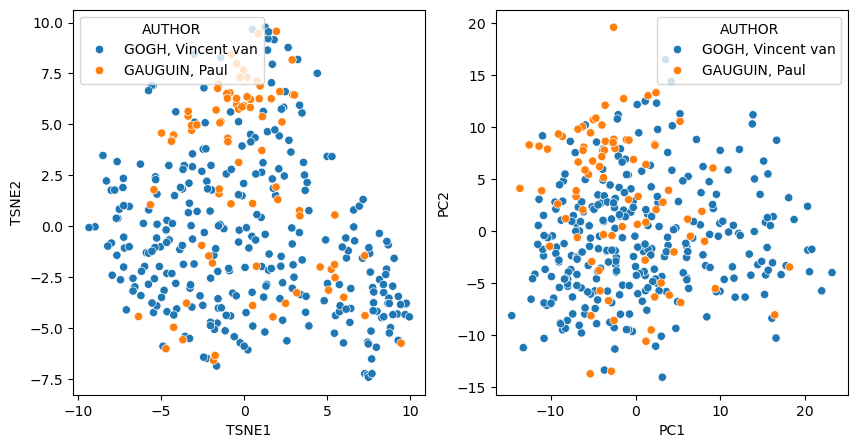

Accuracy of the classifier:  0.9066666666666666
Number of features used: 11
Important features:['Contemporary_Realism', 'Early_Renaissance', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'New_Realism', 'Post_Impressionism', 'Synthetic_Cubism', 'relevant_area', 'maximum_gradient']
Accuracy of the classifier with reduced dimensions:  0.84
Matthews correlation coefficient:  0.4829623412680657
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.6531986531986532
Test performance: 0.64
------------
MATTHEW CORRCOEF
Train performance: 0.4053781553779053
Test performance: 0.33244523803900994
------------
Rules for consequent: GAUGUIN, Paul
----------------
IF Fauvism IS High AND Minimalism IS Low AND Synthetic_Cubism IS High WITH DS 0.33490925034929064, ACC 0.3782051282051282

Rules for consequent: GOGH, Vincent van
----------------
IF Minimalism IS Low AND New_Realism IS Low AND Post_Impressionism IS High 

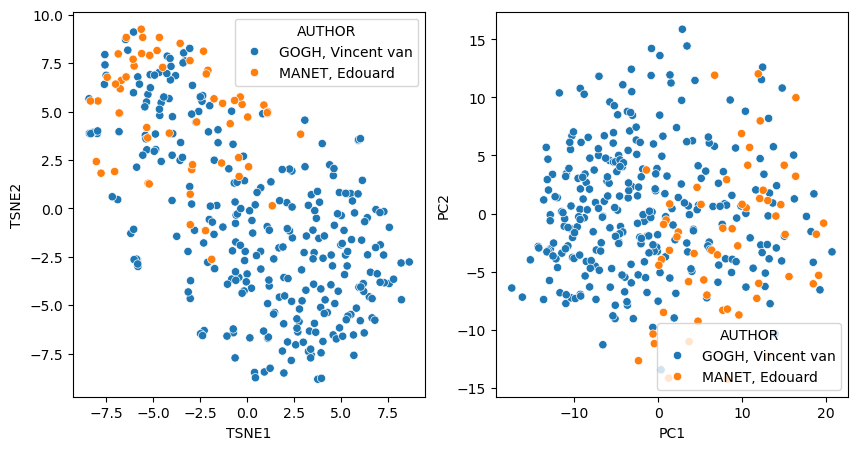

Accuracy of the classifier:  0.8714285714285714
Number of features used: 10
Important features:['Contemporary_Realism', 'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'New_Realism', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism']
Accuracy of the classifier with reduced dimensions:  0.8714285714285714
Matthews correlation coefficient:  0.4617831742117601
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.8741007194244604
Test performance: 0.8714285714285714
------------
MATTHEW CORRCOEF
Train performance: 0.5642676139786237
Test performance: 0.4967795620097622
------------
Rules for consequent: GOGH, Vincent van
----------------
IF Post_Impressionism IS Medium WITH DS 0.19020707423036753, ACC 0.9259259259259259
IF Post_Impressionism IS High AND Rococo IS Low WITH DS 0.596623801578776, ACC 0.9493670886075949
IF Post_Impressionism IS High AND Romanticism IS Low WITH DS 0.43817150740

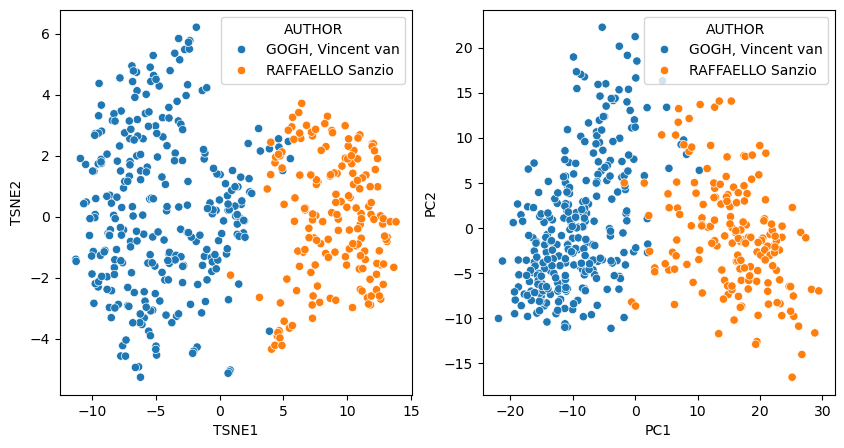

Accuracy of the classifier:  1.0
Number of features used: 2
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque']
Accuracy of the classifier with reduced dimensions:  0.9239130434782609
Matthews correlation coefficient:  0.8376727645257793
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.8994565217391305
Test performance: 0.9021739130434783
------------
MATTHEW CORRCOEF
Train performance: 0.7818479577286097
Test performance: 0.7881618920284886
------------
Rules for consequent: GOGH, Vincent van
----------------
IF Analytical_Cubism IS Low WITH DS 0.5549122946478762, ACC 0.9064039408866995
IF Abstract_Expressionism IS Medium AND Analytical_Cubism IS Medium WITH DS 0.1367584145247111, ACC 0.918918918918919

Rules for consequent: RAFFAELLO Sanzio
----------------
IF Abstract_Expressionism IS Low AND Action_painting IS Low WITH DS 0.3848030518942139, ACC 

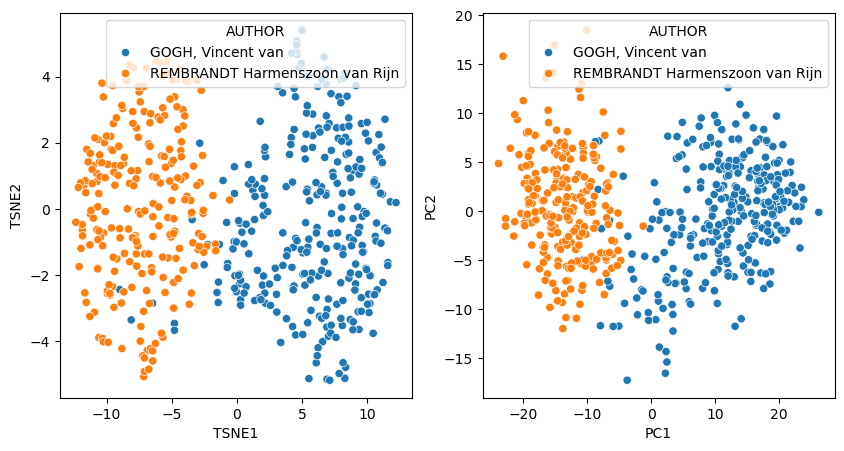

Accuracy of the classifier:  0.9811320754716981
Number of features used: 4
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque']
Accuracy of the classifier with reduced dimensions:  0.9622641509433962
Matthews correlation coefficient:  0.9235485034258926
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.9453681710213777
Test performance: 0.9622641509433962
------------
MATTHEW CORRCOEF
Train performance: 0.8914072688886702
Test performance: 0.9235485034258926
------------
Rules for consequent: GOGH, Vincent van
----------------
IF Baroque IS Low WITH DS 0.632270326784339, ACC 1.0
IF Baroque IS Medium WITH DS 0.3327721711656281, ACC 0.9166666666666666

Rules for consequent: REMBRANDT Harmenszoon van Rijn
----------------
IF Action_painting IS Medium WITH DS 0.31543184173654965, ACC 0.75
IF Abstract_Expressionism IS Low AND Analytical_Cubism IS Low AND Ba

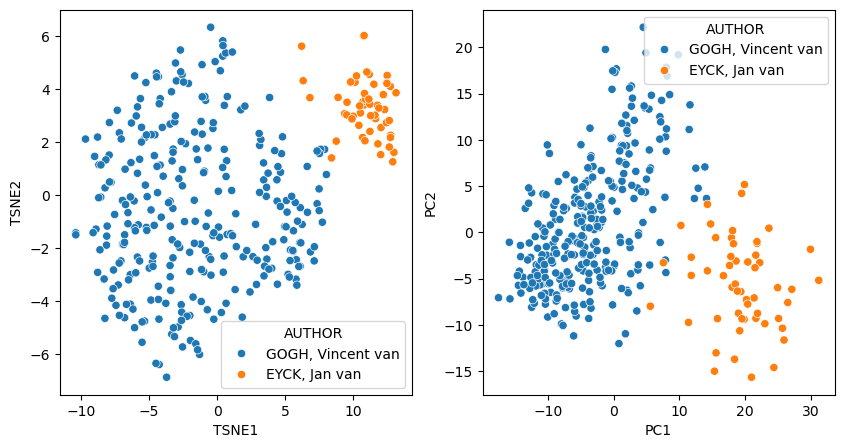

Accuracy of the classifier:  0.9420289855072463
Number of features used: 2
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque']
Accuracy of the classifier with reduced dimensions:  0.9130434782608695
Matthews correlation coefficient:  0.6755485893416928
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.9492753623188406
Test performance: 0.927536231884058
------------
MATTHEW CORRCOEF
Train performance: 0.8037557451242795
Test performance: 0.7204202706379816
------------
Rules for consequent: EYCK, Jan van
----------------
IF Action_painting IS Low AND Analytical_Cubism IS High WITH DS 0.5425515414425038, ACC 0.9032258064516129
IF Analytical_Cubism IS High AND Baroque IS Medium WITH DS 0.3597533401430062, ACC 0.7

Rules for consequent: GOGH, Vincent van
----------------
IF Abstract_Expressionism IS Medium WITH DS 0.3570211963190292, ACC 0.89655172413793

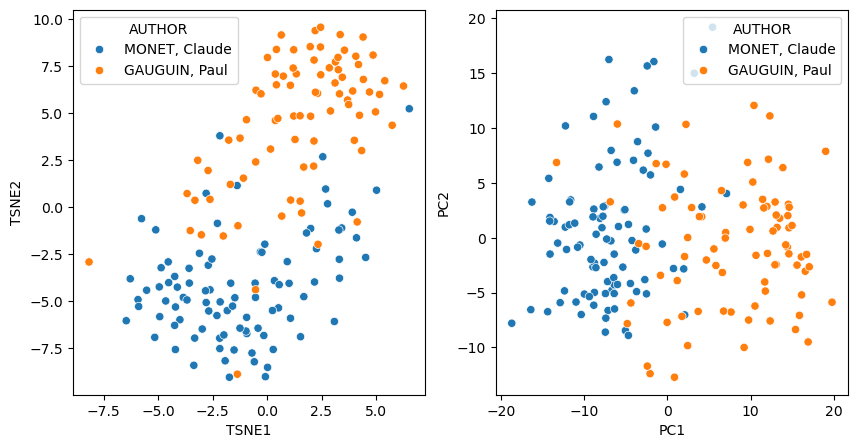

Accuracy of the classifier:  0.9428571428571428
Number of features used: 7
Important features:['Contemporary_Realism', 'Expressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'New_Realism', 'Rococo', 'Romanticism']
Accuracy of the classifier with reduced dimensions:  0.9142857142857143
Matthews correlation coefficient:  0.8278327231656525
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.8695652173913043
Test performance: 0.7714285714285715
------------
MATTHEW CORRCOEF
Train performance: 0.7390029046187614
Test performance: 0.5394736842105263
------------
Rules for consequent: GAUGUIN, Paul
----------------
IF Contemporary_Realism IS Medium AND Minimalism IS Low AND Romanticism IS Medium WITH DS 0.14310292532897936, ACC 0.8113207547169812

Rules for consequent: MONET, Claude
----------------
IF Rococo IS Medium AND Romanticism IS Medium WITH DS 0.36265472623737866, ACC 0.7727272727272727
IF Expressionism

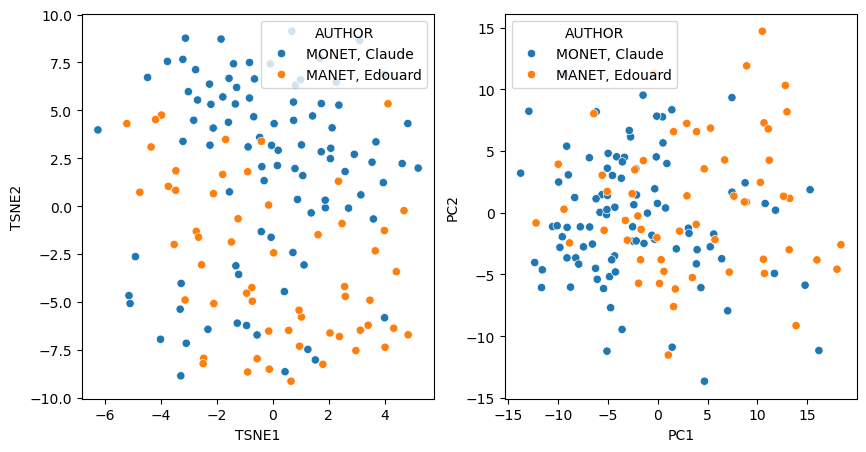

Accuracy of the classifier:  0.8666666666666667
Number of features used: 9
Important features:['Early_Renaissance', 'Expressionism', 'Mannerism_Late_Renaissance', 'New_Realism', 'Northern_Renaissance', 'Pointillism', 'Symbolism', 'Ukiyo_e', 'super_regions']
Accuracy of the classifier with reduced dimensions:  0.9
Matthews correlation coefficient:  0.7925270806437588
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.8991596638655462
Test performance: 0.8
------------
MATTHEW CORRCOEF
Train performance: 0.7861517885325677
Test performance: 0.5877538136452587
------------
Rules for consequent: MANET, Edouard
----------------
IF Early_Renaissance IS Low AND New_Realism IS High AND Northern_Renaissance IS Low WITH DS 0.2335522668027513, ACC 0.8863636363636364

Rules for consequent: MONET, Claude
----------------
IF Mannerism_Late_Renaissance IS Low AND Northern_Renaissance IS Low AND Pointillism IS High WITH DS 0.5

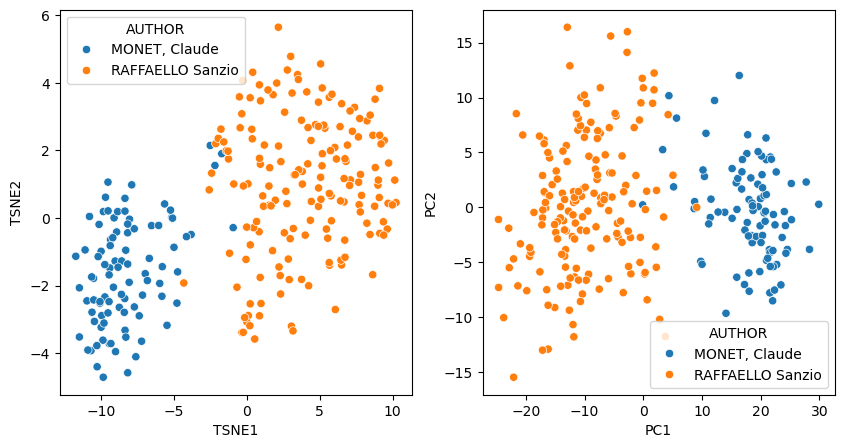

Accuracy of the classifier:  0.9811320754716981
Number of features used: 1
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque', 'Color_Field_Painting', 'Contemporary_Realism', 'Cubism', 'Early_Renaissance', 'Expressionism', 'Fauvism', 'High_Renaissance', 'Impressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism', 'New_Realism', 'Northern_Renaissance', 'Pointillism', 'Pop_Art', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Synthetic_Cubism', 'Ukiyo_e', 'relevant_area']
Accuracy of the classifier with reduced dimensions:  0.9811320754716981
Matthews correlation coefficient:  0.9593230696067405
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 1.0
Test performance: 0.9811320754716981
------------
MATTHEW CORRCOEF
Train performance: 1.0
Test performance: 0.9593230696067405
------------
Rules for consequent:

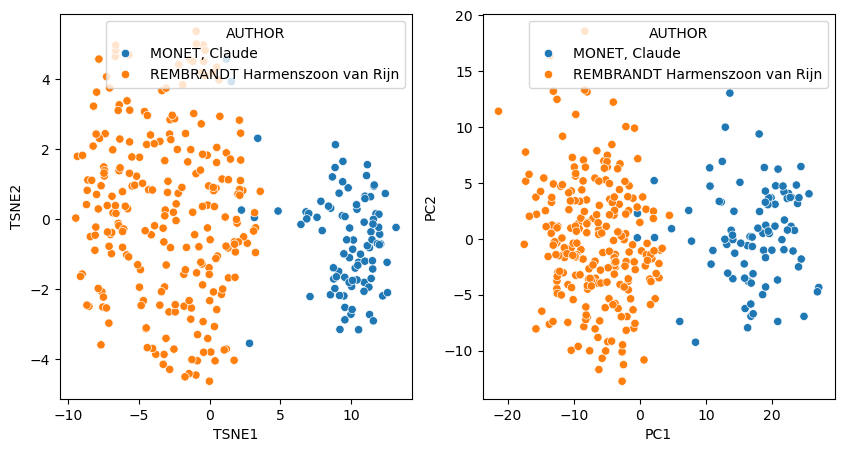

Accuracy of the classifier:  0.9545454545454546
Number of features used: 4
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque']
Accuracy of the classifier with reduced dimensions:  1.0
Matthews correlation coefficient:  1.0
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.9618320610687023
Test performance: 0.9696969696969697
------------
MATTHEW CORRCOEF
Train performance: 0.9053431261604127
Test performance: 0.9264000059363805
------------
Rules for consequent: MONET, Claude
----------------
IF Analytical_Cubism IS Low WITH DS 0.31814960071633763, ACC 1.0

Rules for consequent: REMBRANDT Harmenszoon van Rijn
----------------
IF Baroque IS High WITH DS 0.9264863276298857, ACC 0.949748743718593


*********************************************************
MONET, Claude and EYCK, Jan van
*********************************************************
[t-SNE] Co

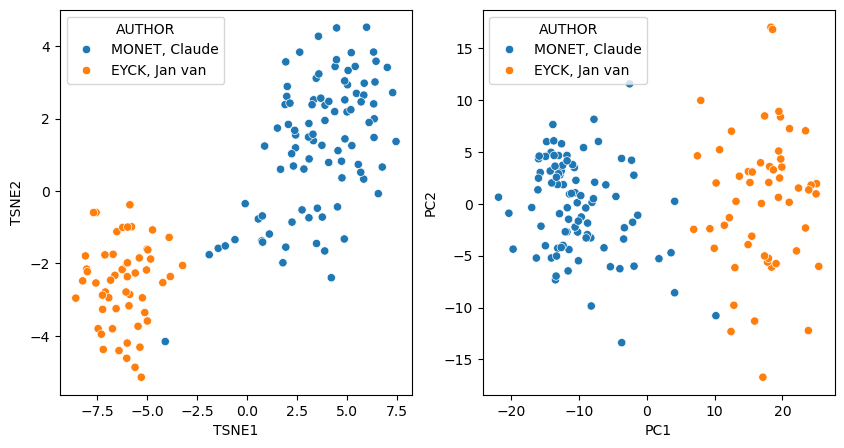

Accuracy of the classifier:  1.0
Number of features used: 2
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque']
Accuracy of the classifier with reduced dimensions:  0.8666666666666667
Matthews correlation coefficient:  0.7129186602870813
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.9827586206896551
Test performance: 0.8666666666666667
------------
MATTHEW CORRCOEF
Train performance: 0.9640414676214709
Test performance: 0.7305170766586324
------------
Rules for consequent: EYCK, Jan van
----------------
IF Action_painting IS Low AND Analytical_Cubism IS High WITH DS 0.6001287254246429, ACC 0.9629629629629629
IF Action_painting IS Medium AND Analytical_Cubism IS High WITH DS 0.23359957088731087, ACC 1.0
IF Abstract_Expressionism IS Low AND Action_painting IS Low WITH DS 0.5010664514657515, ACC 0.9

Rules for consequent: MONET, Claude
--------------

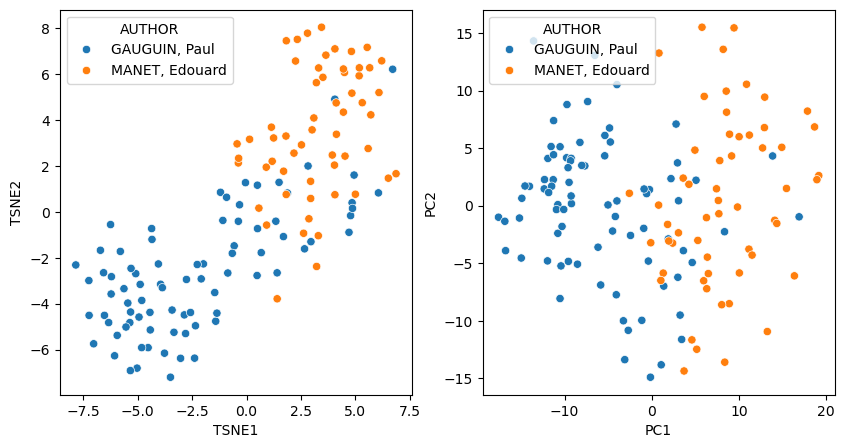

Accuracy of the classifier:  0.8571428571428571
Number of features used: 6
Important features:['Contemporary_Realism', 'Fauvism', 'Naive_Art_Primitivism', 'Realism', 'Rococo', 'Symbolism']
Accuracy of the classifier with reduced dimensions:  0.8571428571428571
Matthews correlation coefficient:  0.7216878364870323
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.8818181818181818
Test performance: 0.8571428571428571
------------
MATTHEW CORRCOEF
Train performance: 0.7565212586013159
Test performance: 0.7216878364870323
------------
Rules for consequent: GAUGUIN, Paul
----------------
IF Contemporary_Realism IS Medium AND Rococo IS Low WITH DS 0.49945032277248086, ACC 0.9
IF Contemporary_Realism IS Low AND Symbolism IS Medium WITH DS 0.11800928505060151, ACC 1.0

Rules for consequent: MANET, Edouard
----------------
IF Naive_Art_Primitivism IS Low WITH DS 0.29964380884266717, ACC 0.7894736842105263
IF Contempora

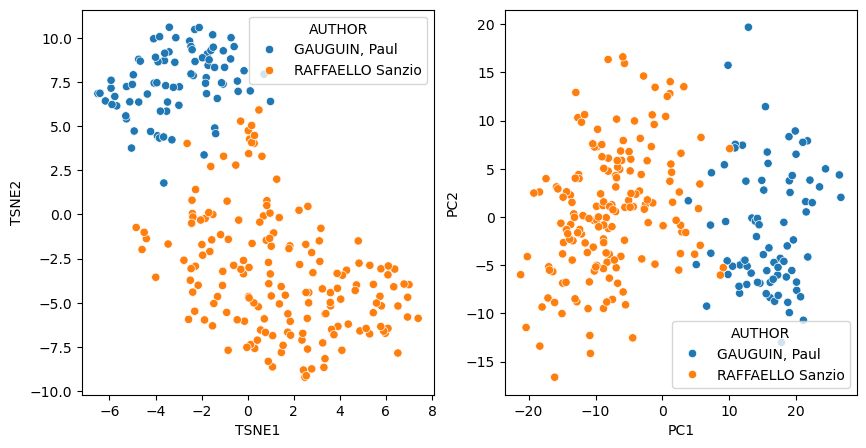

Accuracy of the classifier:  0.96
Number of features used: 3
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque']
Accuracy of the classifier with reduced dimensions:  0.88
Matthews correlation coefficient:  0.7180804893387656
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.925
Test performance: 0.9
------------
MATTHEW CORRCOEF
Train performance: 0.8284295132081437
Test performance: 0.7671932182792478
------------
Rules for consequent: GAUGUIN, Paul
----------------
IF Abstract_Expressionism IS High WITH DS 0.3416283862253562, ACC 0.8611111111111112
IF Abstract_Expressionism IS Medium AND Baroque IS Low WITH DS 0.29611139599801606, ACC 0.9285714285714286

Rules for consequent: RAFFAELLO Sanzio
----------------
IF Abstract_Expressionism IS Low AND Baroque IS Medium WITH DS 0.4494894274165262, ACC 0.8888888888888888
IF Art_Nouveau IS Low WITH DS 0.5438

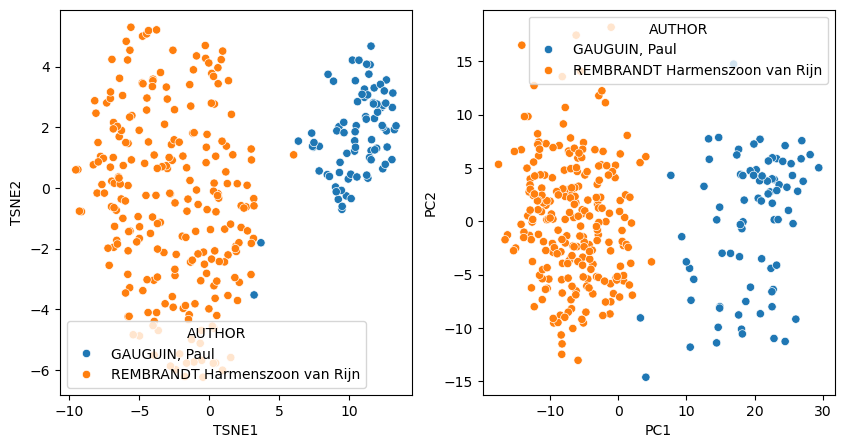

Accuracy of the classifier:  0.984375
Number of features used: 1
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque']
Accuracy of the classifier with reduced dimensions:  1.0
Matthews correlation coefficient:  1.0
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.9802371541501976
Test performance: 1.0
------------
MATTHEW CORRCOEF
Train performance: 0.9482420646399581
Test performance: 1.0
------------
Rules for consequent: GAUGUIN, Paul
----------------
IF Baroque IS Low WITH DS 0.8156278777275289, ACC 1.0
IF Action_painting IS Medium WITH DS 0.10783581672758374, ACC 1.0

Rules for consequent: REMBRANDT Harmenszoon van Rijn
----------------
IF Baroque IS High WITH DS 0.9441809036123372, ACC 0.9740932642487047


*********************************************************
GAUGUIN, Paul and EYCK, Jan van
****************************************************

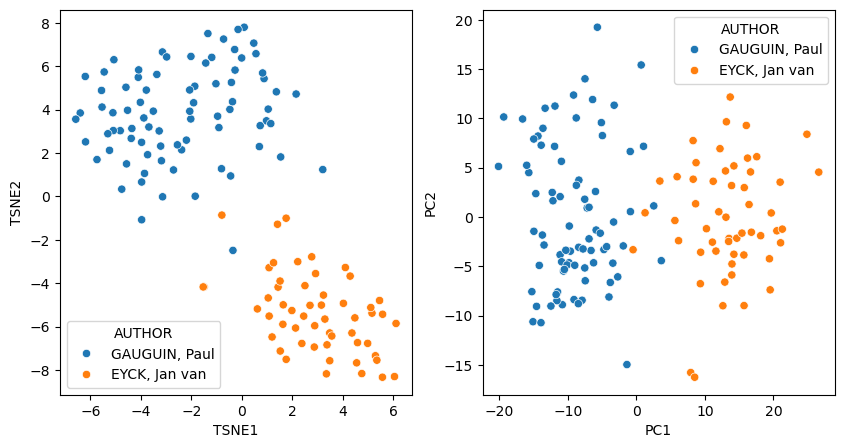

Accuracy of the classifier:  0.8518518518518519
Number of features used: 3
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque', 'Color_Field_Painting', 'Contemporary_Realism', 'Cubism', 'Early_Renaissance', 'Expressionism', 'Fauvism', 'High_Renaissance', 'Impressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism', 'New_Realism', 'Northern_Renaissance', 'Pointillism', 'Pop_Art', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Synthetic_Cubism', 'Ukiyo_e', 'relevant_area', 'maximum_gradient']
Accuracy of the classifier with reduced dimensions:  0.9629629629629629
Matthews correlation coefficient:  0.9270248108869579
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.8703703703703703
Test performance: 0.8518518518518519
------------
MATTHEW CORRCOEF
Train performance: 0.7449170313355317
Test performance: 0.6

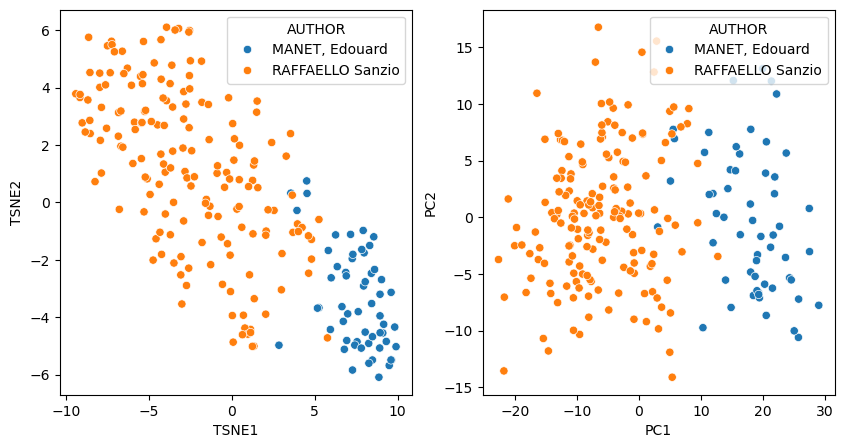

Accuracy of the classifier:  0.9565217391304348
Number of features used: 4
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque']
Accuracy of the classifier with reduced dimensions:  0.8913043478260869
Matthews correlation coefficient:  0.7759356446042894
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.9388888888888889
Test performance: 0.8478260869565217
------------
MATTHEW CORRCOEF
Train performance: 0.8492077756084468
Test performance: 0.6733694387083201
------------
Rules for consequent: MANET, Edouard
----------------
IF Action_painting IS High AND Analytical_Cubism IS Medium WITH DS 0.23279580216479417, ACC 0.8076923076923077
IF Analytical_Cubism IS Low AND Art_Nouveau IS Medium AND Baroque IS Low WITH DS 0.1063983908635596, ACC 1.0
IF Art_Nouveau IS High WITH DS 0.176107139043666, ACC 0.8260869565217391

Rules for consequent: RAFFAELLO Sanzio
-

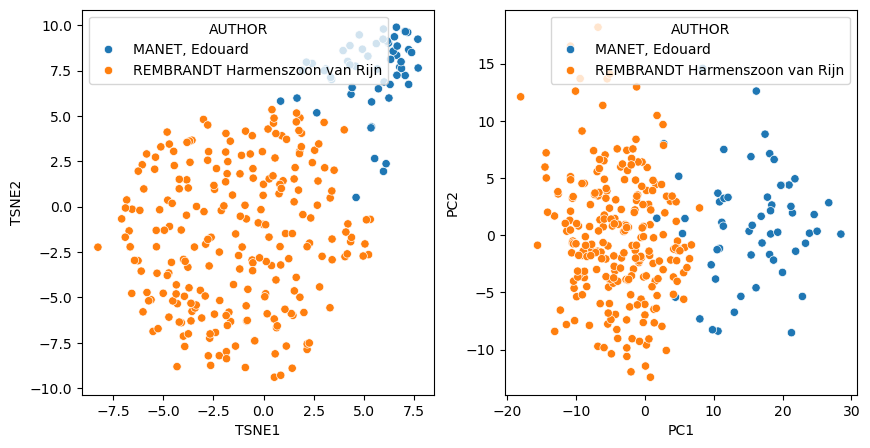

Accuracy of the classifier:  0.9661016949152542
Number of features used: 2
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque']
Accuracy of the classifier with reduced dimensions:  0.9661016949152542
Matthews correlation coefficient:  0.8882575757575758
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.9487179487179487
Test performance: 0.9322033898305084
------------
MATTHEW CORRCOEF
Train performance: 0.8322186501101254
Test performance: 0.7954996078101785
------------
Rules for consequent: MANET, Edouard
----------------
IF Baroque IS Low WITH DS 0.36607987048737767, ACC 1.0
IF Abstract_Expressionism IS Medium AND Baroque IS Medium WITH DS 0.18072429640962112, ACC 0.875
IF Analytical_Cubism IS Low AND Art_Nouveau IS High WITH DS 0.22420919718853405, ACC 1.0

Rules for consequent: REMBRANDT Harmenszoon van Rijn
----------------
IF Analytical_Cubism I

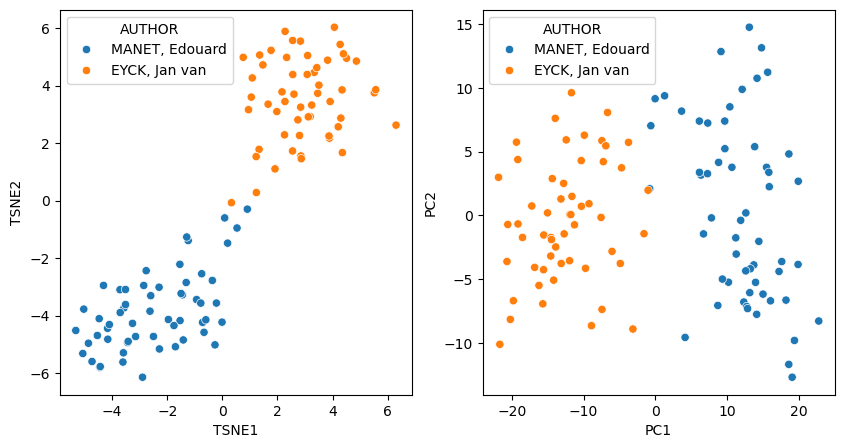

Accuracy of the classifier:  0.9565217391304348
Number of features used: 2
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque']
Accuracy of the classifier with reduced dimensions:  0.9565217391304348
Matthews correlation coefficient:  0.9160572248286889
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.9204545454545454
Test performance: 0.8695652173913043
------------
MATTHEW CORRCOEF
Train performance: 0.852186729667989
Test performance: 0.7424242424242424
------------
Rules for consequent: EYCK, Jan van
----------------
IF Abstract_Expressionism IS Low WITH DS 0.5828859073600643, ACC 0.86

Rules for consequent: MANET, Edouard
----------------
IF Analytical_Cubism IS Low WITH DS 0.6090603774167848, ACC 1.0
IF Art_Nouveau IS High AND Baroque IS Low WITH DS 0.21953569202023104, ACC 1.0


*********************************************************
RAFFAELL

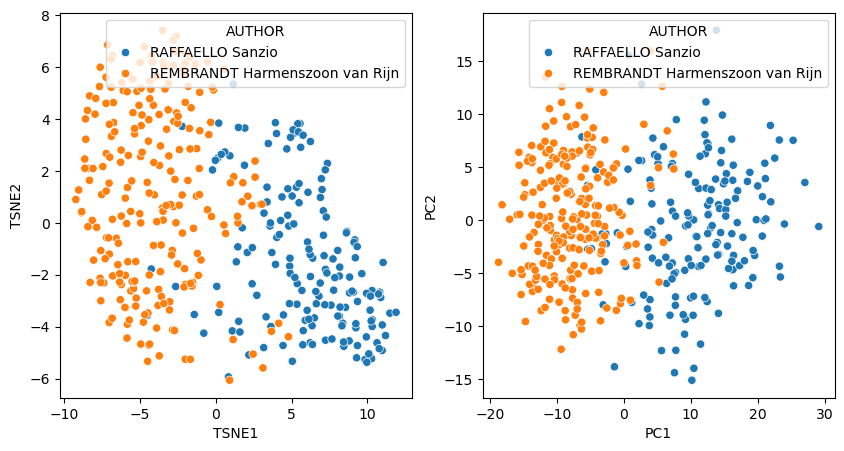

Accuracy of the classifier:  0.9506172839506173
Number of features used: 6
Important features:['Baroque', 'Early_Renaissance', 'High_Renaissance', 'Naive_Art_Primitivism', 'Romanticism', 'relevant_area']
Accuracy of the classifier with reduced dimensions:  0.9506172839506173
Matthews correlation coefficient:  0.9005803996981061
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.9506172839506173
Test performance: 0.8271604938271605
------------
MATTHEW CORRCOEF
Train performance: 0.900408308064935
Test performance: 0.6914013459445846
------------
Rules for consequent: RAFFAELLO Sanzio
----------------
IF Romanticism IS Low WITH DS 0.4278901074910823, ACC 0.8363636363636363
IF Baroque IS Medium AND Early_Renaissance IS High WITH DS 0.5748515979400614, ACC 0.9659090909090909

Rules for consequent: REMBRANDT Harmenszoon van Rijn
----------------
IF Naive_Art_Primitivism IS Low AND relevant_area IS Medium WITH DS 0.

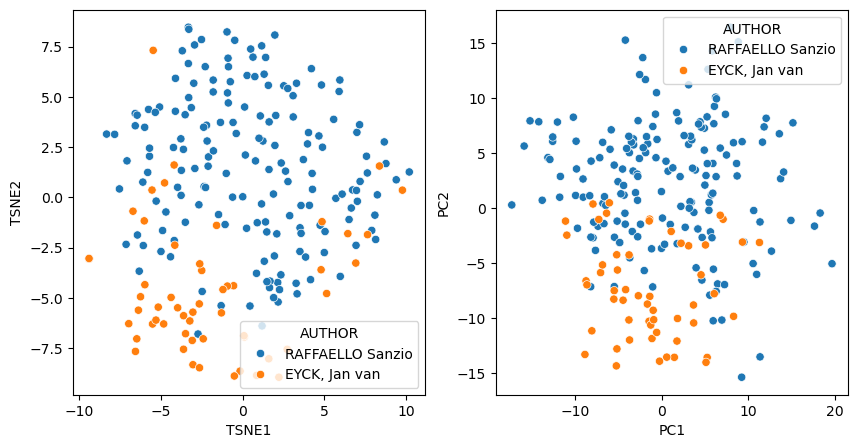

Accuracy of the classifier:  0.8444444444444444
Number of features used: 8
Important features:['Analytical_Cubism', 'High_Renaissance', 'Naive_Art_Primitivism', 'Northern_Renaissance', 'Pop_Art', 'Post_Impressionism', 'Realism', 'relevant_area']
Accuracy of the classifier with reduced dimensions:  0.8444444444444444
Matthews correlation coefficient:  0.5470030291672947
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.7921348314606742
Test performance: 0.7555555555555555
------------
MATTHEW CORRCOEF
Train performance: 0.3193625932822799
Test performance: 0.1282456990835024
------------
Rules for consequent: EYCK, Jan van
----------------
IF Pop_Art IS Low AND Post_Impressionism IS Medium WITH DS 0.2328087242083323, ACC 0.7142857142857143
IF High_Renaissance IS Medium AND Northern_Renaissance IS High AND Post_Impressionism IS Low WITH DS 0.2044735666139034, ACC 0.8

Rules for consequent: RAFFAELLO Sanzio
-----

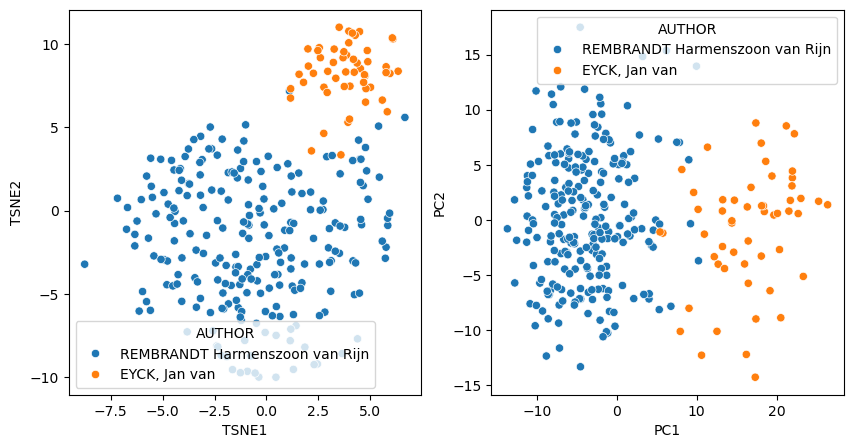

Accuracy of the classifier:  0.9310344827586207
Number of features used: 3
Important features:['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque']
Accuracy of the classifier with reduced dimensions:  0.9310344827586207
Matthews correlation coefficient:  0.7756286266924565
Training fuzzy classifier: 15 rules,  4 ants,  100 generations,  50 population size
------------
ACCURACY
Train performance: 0.9094827586206896
Test performance: 0.8275862068965517
------------
MATTHEW CORRCOEF
Train performance: 0.6880870255675298
Test performance: 0.43907156673114117
------------
Rules for consequent: EYCK, Jan van
----------------
IF Baroque IS Medium WITH DS 0.4642686411332155, ACC 0.7777777777777778
IF Baroque IS Low WITH DS 0.14535980396603057, ACC 1.0

Rules for consequent: REMBRANDT Harmenszoon van Rijn
----------------
IF Analytical_Cubism IS Low WITH DS 0.3951577289538725, ACC 0.9666666666666667
IF Art_Nouveau IS Low AND Baroque IS High WITH DS 0.69881

In [12]:
%%time
for combination in itertools.combinations(authors, 2):
    i = combination[0]
    j = combination[1]
    print('*********************************************************')
    print(f'{i} and {j}')
    print('*********************************************************')
    try:
        X, y = load_explainable_features()
        X_artists, y_artists = create_full_dataset(X, y, i, j)
        dimensionality_reduction_plots(X_artists, y_artists)
        X, X_artists_train, y_artists_train, X_artists_test, y_artists_test = gbc_finetune(X, X_artists, y_artists)
        generate_rules(X, X_artists_train, y_artists_train, X_artists_test, y_artists_test)
    except: 
        print("Could not generate fuzzy rules!")